## Cell type deconvoluation & ST velocity

### Key APIs
- expDeconv
- expVeloImp

#### External packages:
[scvelo](https://scvelo.readthedocs.io/en/stable/installation/)

### I. Cell type deconvoluation
Translate cell types from single cell reference to ST data (full-rank cluster mode)
- In addition to shared genes, `TransDeconv` requires single cell type lables and per-cell annotations as input;
- After fitting the translation function, `TransDeconv` will output the predictions as well as the weights for each cell type
```python3
preds, weight = expDeconv(
            df_ref=df_ref, 
            df_tgt=df_tgt, 
            classes=classes,
            ct_list=ct_list,
            n_epochs=8000,
            lr=1e-2,
            seed=seed,
            device=device
            ) 
```

In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
from transpa.util import expVeloImp, leiden_cluster, expDeconv
import torch
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# load preprocessed scRNA-seq and spatial datasets
RNA = scv.read('../../data/Mouse_brain/RNA_adata.h5ad')
HybISS = scv.read('../../data/Mouse_brain/HybISS_adata.h5ad')
RNA, HybISS

(AnnData object with n_obs × n_vars = 40733 × 16907
     obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
     var: 'GeneName', 'gene_count_corr'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 4628 × 119
     obs: 'n_counts'
     var: 'GeneName'
     obsm: 'X_xy_loc', 'xy_loc')

The following code prepares input for expDeconv, it
- filters SC types with less than 2 samples, 
- select top cell-type marker genes as training candidate,
- align training & testing genes
- prepare cell cluster labels and annotations


In [2]:
sc.pp.pca(HybISS, n_comps=30)
celltype_counts = RNA.obs['Class'].value_counts()

celltype_drop = celltype_counts.index[celltype_counts < 2]
rna_adata = RNA.copy()
if len(celltype_drop):
    print(f'Drop celltype {list(celltype_drop)} (contain less 2 samples)')
    rna_adata = RNA[~RNA.obs['Class'].isin(celltype_drop),].copy()
    
sc.tl.rank_genes_groups(rna_adata, groupby="Class", use_raw=False, method="wilcoxon")
markers_df = pd.DataFrame(rna_adata.uns["rank_genes_groups"]["names"]).iloc[0:100, :]

genes_sc = np.unique(markers_df.melt().value.values)

gene = np.intersect1d(genes_sc, HybISS.var_names)
rna_adata = rna_adata[:, gene].copy()
spa_adata = HybISS[:, gene].copy()

df_ref = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)
df_tgt = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)

shared_gene = np.intersect1d(df_ref.columns, df_tgt.columns)
df_ref = df_ref[shared_gene]
df_tgt = df_tgt[shared_gene]

classes = rna_adata.obs.Class.values
ct_list = np.unique(classes)

- Run the main cell type deconvoluation method
- Normalize result and select the top1 cell type


In [3]:
preds, weight = expDeconv(
            df_ref=df_ref, 
            df_tgt=df_tgt, 
            classes=classes,
            ct_list=ct_list,
            n_epochs=8000,
            lr=1e-2,
            seed=seed,
            device=device
            ) 

df_results = pd.DataFrame(weight, columns=ct_list)

df_results = (df_results.T/df_results.sum(axis=1)).T

HybISS.obs['Class'] = df_results.columns[np.argmax(df_results.values, axis=1)]

[LinTrans] Epoch: 8000/8000, loss: 0.892779: 100%|██████████| 8000/8000 [00:47<00:00, 169.39it/s]


#### Plot the deconvolution result

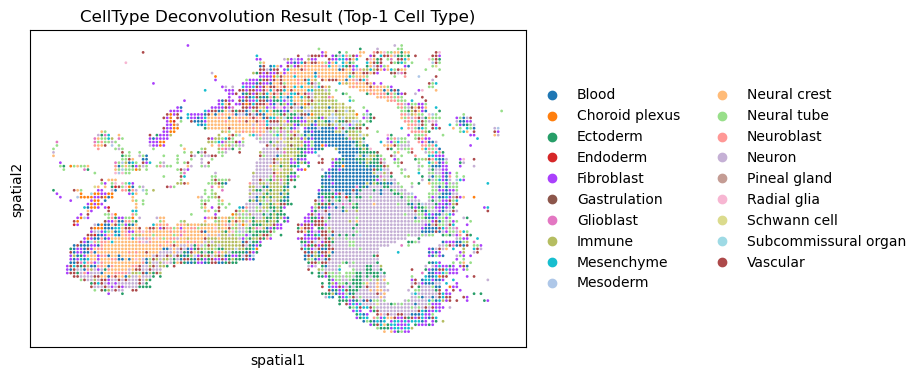

In [4]:
HybISS.obsm['spatial'] = HybISS.obsm['X_xy_loc'] * np.array([[1, -1]])
sc.pl.spatial(HybISS, color='Class', title="CellType Deconvolution Result (Top-1 Cell Type)", spot_size=0.8)


### II. RNA velocity imputation
Translate spliced and unspliced count matrices from SC to ST domain (Low-rank cell mode), before applying velocity estimation methods.
- Additional inputs include Spliced and Unspliced input matrices
- Output is imputed Spliced, Unspliced and other related matrics
```python3
res = expVeloImp(
            df_ref=raw_scrna_df,
            df_tgt=raw_spatial_df,
            S=RNA.layers['spliced'],
            U=RNA.layers['unspliced'],
            V=RNA.layers['spliced'],
            train_gene=raw_shared_gene,
            test_gene=RNA.var_names,
            signature_mode='cell',
            mapping_mode='lowrank', 
            classes='celltype_prediction',
            n_epochs=1000,
            seed=seed,
            device=device)
```

#### Check spliced and unspliced expressions

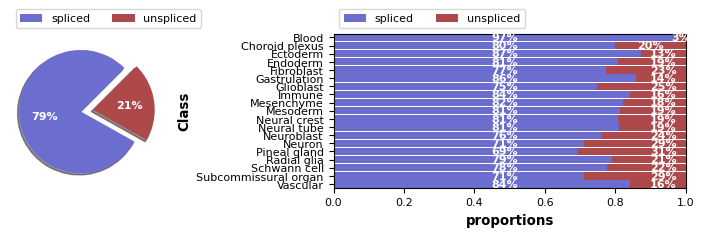

Extracted 2031 highly variable genes.


In [5]:
scv.pl.proportions(RNA, 'Class')
scv.pp.filter_and_normalize(RNA, n_top_genes=2000, retain_genes=HybISS.var_names)

#### SC RNA Velocity

computing neighbors
    finished (0:00:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:25) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/96 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:55) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:08) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


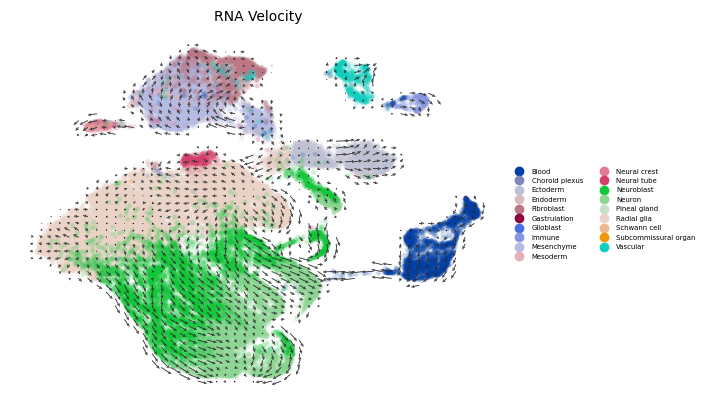

In [6]:
scv.pp.moments(RNA, n_pcs=30, n_neighbors=30)
sc.tl.umap(RNA)
scv.tl.velocity(RNA, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(RNA, vkey='stc_velocity', n_jobs=10)
scv.pl.velocity_embedding_grid(RNA,  
                                vkey="stc_velocity", 
                                basis='X_umap', color="Class",
                                legend_fontsize=5,
                                size=50,
                                legend_loc='right',
                                arrow_length=2,
                                dpi=100, 
                                title='RNA Velocity')

####  Prepare data

In [7]:
raw_spatial_df  = pd.DataFrame(HybISS.X, columns=HybISS.var_names)
raw_scrna_df    = pd.DataFrame(RNA.X, columns=RNA.var_names).astype(pd.SparseDtype("float32", 0))
raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((4628, 119), (40733, 2031), (117,))

#### Run main imputation method for ST velocity estimation

In [8]:
res = expVeloImp(
            df_ref=raw_scrna_df,
            df_tgt=raw_spatial_df,
            S=RNA.layers['spliced'],
            U=RNA.layers['unspliced'],
            V=RNA.layers['spliced'],
            train_gene=raw_shared_gene,
            test_gene=RNA.var_names,
            signature_mode='cell',
            mapping_mode='lowrank', 
            classes='celltype_prediction',
            n_epochs=1000,
            seed=seed,
            device=device)
S, U, V, X = res

[TransImp] Epoch: 1000/1000, loss: 0.447701, (IMP) 0.447701: 100%|██████████| 1000/1000 [00:04<00:00, 202.13it/s]


#### Organize new anndata for imputation result

In [9]:
imp_adata = sc.AnnData(X)
imp_adata.obs = HybISS.obs.copy()
imp_adata.obsm = HybISS.obsm.copy()
imp_adata.var_names = RNA.var_names
imp_adata.obs_names = HybISS.obs_names
imp_adata.uns = HybISS.uns
imp_adata.uns['Class_colors'] = RNA.uns['Class_colors']

imp_adata.layers['spliced'] = S
imp_adata.layers['unspliced'] = U

scv.pp.normalize_per_cell(imp_adata, enforce=True)
sc.pp.scale(imp_adata)
sc.tl.pca(imp_adata)
sc.pp.neighbors(imp_adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(imp_adata)
sc.tl.leiden(imp_adata)


scv.pp.moments(imp_adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(imp_adata, vkey='stc_velocity')
scv.tl.velocity_graph(imp_adata, vkey='stc_velocity', n_jobs=10)
scv.tl.velocity_confidence(imp_adata, vkey='stc_velocity')

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/96 cores)
    finished (0:00:03) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)


#### Ploting ST velocity

computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_xy_loc', embedded velocity vectors (adata.obsm)


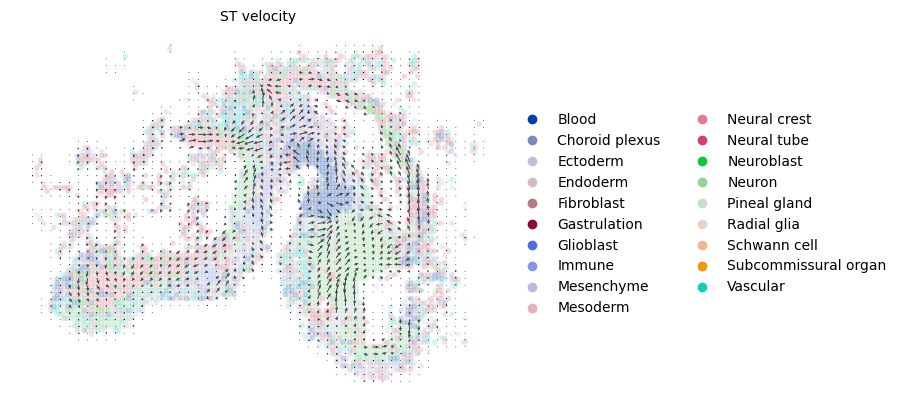

In [10]:
scv.pl.velocity_embedding_grid(imp_adata,  
                                vkey="stc_velocity", 
                                basis='xy_loc', color="Class",
                                # legend_fontsize=2,
                                size=60,
                                legend_loc='right',
                                # smooth=0.5,
                                dpi=100, 
                                title='ST velocity')